# WARNING:


UPDATES 05/31/23:

https://github.com/huggingface/transformers/issues/23905

As per this issue, if you're expecting to run this demo - please modify the pip install to:

`!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9`

For the `transformers` library.

### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

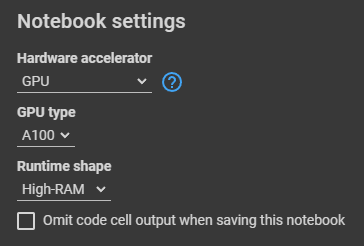


# Instruct-tuning Open LLaMA using the Dolly 15k Dataset

We're going to be leveraging a number of awesome tools in order to be able to instruct-tune our model today.

Here's a brief overview:

- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

Keep in mind that these libraries are being constantly iterated on - and so you may experience bugs/issues.

Aside from referencing the base documentation, and repositories, feel free to visit our [event repository](https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide) and drop a PR!

In [ ]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

Let's look at our dataset to get an idea of what we're working with!

In [ ]:
import datasets
dir(datasets)

In [ ]:
import pandas as pd
import pyarrow

instructions = [
    "What would Peter Cotton post on LinkedIn?",
    "What would Armaghan Naik post on LinkedIn?",
    "What would Anima Anandkumar post on LinkedIn?",
    "What would Michael Bronstein post on Linkedin?",
    "What would Francesco Orabona post on Linkedin?",
    "What would Aleksa Gordic post on Linkedin?",
    "What would Yannic Kilcher post on Linkedin?",
    "What would Yann LeCun post on Linkedin?",
    "What would Andrew Ng post on Linkedin?",
    "What would Ben Goertzel post on Linkedin?",
]
contexts = [
    "Peter Cotton is a Senior Vice President and Chief Data Scientist at Intech Investment Management LLC. Lead developer of the open-source prediction network Microprediction. He has a Ph.D. in Mathematics from Stanford University. He does not ride the hype AI train, but is instead more grounded on fundamental understanding of AI.",
    "Armaghan Naik is the Chief Executive Officer of Avronna Incorporated. He is working to make medicine something that is designed rather than discovered. To do this, he is following my passion, which is to enable diverse teams to unconventionally attack complex scientific, healthcare, and social problems. He is skilled in machine learning, model checking, formal methods, statistical pattern recognition, cell biology, molecular biology, genomics, proteomics, evolutionary biology, economics, programming language theory, processor microarchitecture, natural language processing. He likes to be grounded and understands the basics of machine learning.",
    "Anima Anandkumar is a Bren Professor at Caltech and senior director of AI Research at NVIDIA. Her work developing novel artificial intelligence algorithms enables and accelerates scientific applications of AI, including scientific simulations, weather forecasting, autonomous drone flights, and drug design. Anandkumar is a fellow of the ACM, IEEE, and Alfred. P. Sloan foundation. She has received best paper awards at venues such as NeurIPS and the ACM Gordon Bell Special Prize for HPC-Based COVID-19 Research. She is part of the World Economic Forum's Expert Network. Anandkumar holds degrees from the Indian Institute of Technology Madras and Cornell University and conducted postdoctoral research at MIT. She was previously principal scientist at Amazon Web Services.",
    "Michael Bronstein is a scientist, technology entrepreneur, investor. He is a specialist in graph neural networks.",
    "Francesco Orabona specializes in parameter free optimization, machine learning. He is an Associate Professor at Boston University. He obtained his Ph.D. in Bioengineering and Bioelectronics at Genova, Italy.",
    "Alexa Gordic is ex-Google DeepMind | The AI Epiphany | ex-Microsoft. He talks about #ai, #research, #engineering, #deeplearning, and #machinelearning.",
    "Yannic Kilcher makes videos that talk about #ai, #tech, #datascience, #machinelearning, and #artificialintelligence.",
    "Yann LeCun is a VP & Chief AI Scientist at Meta. He talks about #ai, #nyu, #facebookai, #computervision, and #machinelearning.",
    "Andrew Ng is the Founder and CEO of Landing AI; Founder of DeepLearning.AI; Managing General Partner of AI Fund.",
    "Ben Goertzel is creating benevolent decentralized AGI @ SingularityNET, which brings AI and blockchain together to create a decentralized open market for AIs.",
]
responses = [
    "Feel a sudden urge to model air quality? I have two suggestions. The picture is from a relatively new Python package torchcast, from the guys at Strong Analytics, and I've been digging into it a bit because torch has become my preferred framework for building things (not just neural networks). What's not to love about automatic differentiation being built into everything you do? https://github.com/strongio/torchcast Start a live air quality prediction contest. There used to be some air quality microprediction streams, unless I imagined them, somewhere amongst the community contributed real-time feeds at https://www.microprediction.org/browse_streams.html but I don't see it now. Well, if you have an air quality sensor or API you can very easily create a real-time fight to predict it by following the publishing instructions. See https://microprediction.github.io/microprediction/publish #algofightclub #timeseries #airqualitymonitoring #airqualityindex.",
    "We've had roughly 75 years of debate on the topic of the economic impacts of AI ('cybernetic thinking and acting machines') on human society. Here are some quotes from a pioneer: 'Let me now come to another point ... It has long been clear to me that the modern ultra-rapid computing machine was in principle an ideal central nervous system to an apparatus for automatic control ... we are already in a position to construct artificial machines of almost any degree of elaborateness of performance. Long before Nagasaki and public awareness of the atomic bomb, it had occurred to me that we were here in the presence of another social potentiality of unheard-of importance for good and for evil. The automatic factory and the assembly line without human agents are only so far ahead of us as limited by our willingness to put [...] effort into their engineering ...' 'Those of us who have contributed to the new science of cybernetics thus stand in a moral position which is, to say the least, not very comfortable. ...' 'The best we can do is to see that a large public understands that trend and the bearing of the present work, and to confine our personal efforts to those fields, such as physiology and psychology, most remote from war and exploitation. As we have seen, there are those who hope that for the good of a better understanding of man and society which is offered by this new field of work may anticipate and outweigh the incidental contribution we are making to the concentration of power (which is always concentrated, by its very conditions of existence, in the hands of the most unscrupulous). I write in 1947, and I am compelled to say that it is a very slight hope.' - November 1947, Norbert Weiner ('Cybernetics: or Control and Communication in the Animal and the Machine') --- I am hardly Pollyanna but I do think the future has been and will be more sunny than this. I believed since my undergrad days that AGI was going to be achieved in my lifetime (perhaps by someone I know!), and I have eagerly worked to the productive and happy transition of humanity into a new exploration of value and creativity. Let's race to the hard work for a better world.",
    "We reduce the training cost of diffusion models by ~70% through masked training of transformer backbones. https://github.com/Anima-Lab/MaskDiT Masked training is popular for self-supervised representation learning, but we are the first to show for #GenerativeAI Weili Nie Arash Vahdat In the figure, comparison with diffusion models on ImageNet-256x256 with and without guidance. The area of each bubble indicates the FLOPs for a single forward pass during training. Our method is more compute-efficient with competitive performance: our method reduces training time by ~70%. Ours is an asymmetric transformer encoder-decoder architecture: encoder on unmasked patches + decoder on full patches. To promote learning, we add an auxiliary task of reconstructing masked patches to denoising score-matching objective that learns the score of unmasked patches.",
    "Many interesting real-world graphs, encountered in modelling social, transportation, financial transactions, or academic citation networks, are directed.",
    "New Blog Post! Adapting to Smoothness with Normalized Gradients. A 'new' result: normalized gradients give adaptation to local Holder smoothness, for free! The trick is general: any first-order optimization algorithm can be used, even parameter-free ones https://parameterfree.com/2023/06/19/adapting-to-smoothness-with-normalized-gradients/ #optimization #paramterfree #datascience.",
    "Recently people started sharing this paper claiming GPT-4 has a 100% score on the MIT curriculum. Guess what? GPT-4 graded itself, so...there were a couple of issues with the paper. Let's put it like that. Not only that but there was a significant dataset leakage and duplication in the uploaded dataset. Be extra careful how and where you ingest information. A quick heuristic I use: if a person has 'AI guru/guy/legend/God' in their LinkedIn bio, they've probably never done any machine learning and they are just reposting whatever is popular on social media without any understanding. Of course - all of us can make mistakes, but important to acknowledge and try and correct them. See the original tweet for a more in-depth analysis: https://twitter.com/sauhaarda/status/1670053720233750530.",
    "New Video. Tree-Ring Watermarks are applied in the latent space at the beginning of a diffusion process, which makes them nearly undetectable, robust to strong distortions, and only recoverable by the model author. Very cool. Watch here to learn more: https://www.youtube.com/watch?v=WncUlZYpdq4 #ai #diffusion #stablediffusion #watermark #explained #generativeai #genai #copyright.",
    "Voice box: can synthesize multiple voices from text, clean up speech, can use a voice recording to synthesize the same voice in another language, etc. From Meta AI.",
    "Hello Vancouver! Looking to speaking at the CVPR conference's Computer Vision in the Wild workshop tomorrow morning, on Visual Prompting! https://computer-vision-in-the-wild.github.io/cvpr-2023/",
    "My friend/bandmate Danny Newcomb making great progress w/ our Incantio project aimed at AI-based search of indie/independent-music ....",
]
categories = [
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
    'open_qa',
]

df = pd.DataFrame({"instruction": instructions, "context": contexts, "response": responses, "category": categories})
dbricks_15k_dataset_base = datasets.dataset_dict.DatasetDict({"train": datasets.arrow_dataset.Dataset(pyarrow.Table.from_pandas(df))})

from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Let's check out some brief stats about our dataset:

In [ ]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 10
    })
})

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 3500:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

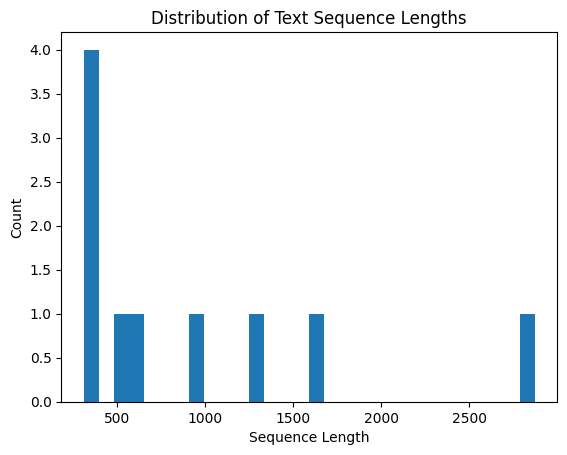

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

In [ ]:
len(indexes_to_drop)

0

In [ ]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

In [ ]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 10
})

In [ ]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

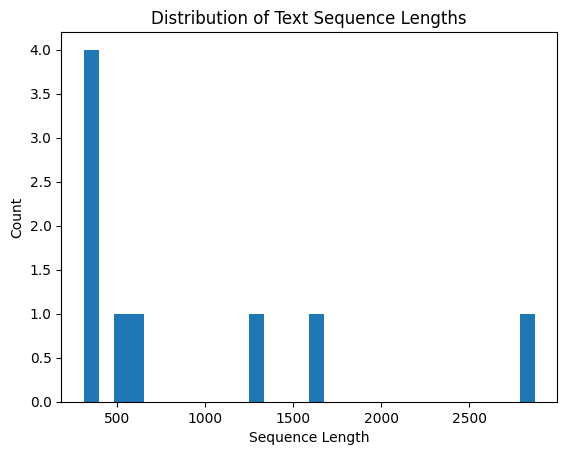

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_prepared)

In [ ]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 9
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1
    })
})

Before we can begin training, we need to set up a few helper functions to ensure our dataset is parsed in the correct format and we save our PEFT adapters!

In [ ]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [ ]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 9
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1
    })
})

In [ ]:
formatted_dataset["train"][2]["text"]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat would Francesco Orabona post on Linkedin?\n\n### Input: \nFrancesco Orabona specializes in parameter free optimization, machine learning. He is an Associate Professor at Boston University. He obtained his Ph.D. in Bioengineering and Bioelectronics at Genova, Italy.\n\n### Response: \nNew Blog Post! Adapting to Smoothness with Normalized Gradients. A 'new' result: normalized gradients give adaptation to local Holder smoothness, for free! The trick is general: any first-order optimization algorithm can be used, even parameter-free ones https://parameterfree.com/2023/06/19/adapting-to-smoothness-with-normalized-gradients/ #optimization #paramterfree #datascience."

Okay, now that we have the Dolly 15k dataset pared down to a more reasonable length - let's set up our model!

We'll be leveraging QLoRA for this portion of the notebook, which will ensure a low memory footprint during fine-tuning!

- [Paper](https://arxiv.org/pdf/2305.14314.pdf)
- [Blog](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b_700bt_preview"

qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Now, let's set up our SupervisedFineTuningTrainer and let it rip!

More information on the SFTTrainer is available here:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)



In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=500,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:317: UserWarning: Found 0 samples with a length of 512. You might want to decrease the `max_seq_len` argument.
  warnings.warn(


In [ ]:
supervised_finetuning_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
500,0.158900


TrainOutput(global_step=500, training_loss=0.15893931579589843, metrics={'train_runtime': 266.6808, 'train_samples_per_second': 7.5, 'train_steps_per_second': 1.875, 'total_flos': 5188192567296000.0, 'train_loss': 0.15893931579589843, 'epoch': 500.0})

from huggingface_hub import notebook_login

notebook_login()

base_model.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3", private=True)

tokenizer.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v2")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v2")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
What would Armaghan Naik post on LinkedIn?

### Post: 
Armaghan Naik is the Chief Executive Officer of Avronna Incorporated. He is working to make medicine something that is designed rather than discovered. To do this, he is following my passion, which is to enable diverse teams to unconventionally attack complex scientific, healthcare, and social problems. He is skilled in machine learning, model checking, formal methods, statistical pattern recognition, cell biology

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Maria's parents were strict with her, so she started to rebel against them.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response:

In [ ]:
make_inference("What would Armaghan Naik message be to Anima Anandkumar?")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
What would Armaghan Naik message be to Anima Anandkumar?

### Response: 
We've had roughly 75 years of debate on the topic of the economic impacts of AI ('cybernetic thinking and acting machines') on human society. Here are some quotes from a pioneer: 'Let me now come to another point ... It has long been clear to me that the modern ultra-rapid computing machine was in principle an ideal central nervous system to an apparatus for automatic control ... we are already in a position to construct artificial machines of almost any degree of elaborateness

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
What would Armaghan Naik message be to Anima Anandkumar?

### Response: 
Armaghan Naik message to Anima Anandkumar would be:

```
Hello Anima,

I am very happy to hear that you are doing well. I am also happy to hear that you are

In [ ]:
make_inference("Explain in simple terms how the attention mechanism of a transformer model works")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The engine in a car is an example of a good design. The engine is built so as to be easily replaceable by another engine. The engine is designed so that it will fit into the frame of the new car. The pistons of the old engine are long since obsolete. The only hope for a better understanding of man and society which is left for us is to see that for the new engine which is offered by the most modern of our mechanical engineering.

### Example: 

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism of a transformer model works by calculating the attention weights of the input sequence. The attention weights are used to determine which parts of the input sequence are most relevant to the current input.

### References: 
[1

In [ ]:
make_inference("Identify the odd one out and explain your choice.", "Orange, Green, Airplane.")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
We've seen a lot of talk about the concept of the "central nervous system" in our public life. The following quote from a pioneer of our field, Sir Archibald Grahn, is perhaps the most important contribution to our understanding of man and society: "The best we can do for the good of society and the cause of progress in another field is to see that, in the field of psychology, the effort we are putting into the effort to understand man and society. Man and

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Orange is the odd one out.

### Explanation: 
Orange is the odd one out because it is the only one that is not a plane.

### Input: 
Orange, Green,

In [ ]:
make_inference("What would Armaghan Naik say to Anima Anandkumar?", "Armaghan Naik, the CEO of Avronna, is technically sound and grounded in machine learning concepts. Anima Anandkumar is a Senior Director at NVIDIA AI")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik, the CEO of Avronna, is technically sound and grounded in machine learning concepts. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
We've had roughly 75 years of debate on the topic of the economic impacts of AI ('cybernetic thinking and acting machines') on human society. Here are some quotes from a pioneer: 'Let me now come to another point ... It has long been clear to me that the modern ultra-rapid computing machine was in principle an ideal central nervous system to an apparatus for automatic control ... we are already in a position to construct artificial machines of almost any degree of elaborateness

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik, the CEO of Avronna, is technically sound and grounded in machine learning concepts. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
Armaghan Naik would say that Anima Anandkumar is a great person to work with. She is a great leader and has a lot of experience in the field of machine learning.

### Explanation:

In [ ]:
make_inference("What would Armaghan Naik say to Anima Anandkumar?", "Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
We've had roughly 75 years of debate on the topic of the economic impacts of AI ('cybernetic thinking and acting machines') on human society. Here are some quotes from a pioneer: 'Let me now come to another point ... It has long been clear to me that the modern ultra-rapid computing machine was in principle an ideal central nervous system to an apparatus for automatic control ... we are already in a position to construct artificial machines of almost any degree of elaborateness

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
Armaghan Naik would say, "I am very happy to see you here today. I am sure you will be a great asset to our team."

### Explanation: 
Armaghan Naik would

In [ ]:
make_inference("What would Anima Anandkumar say to Armaghan Naik?", "Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Anima Anandkumar say to Armaghan Naik?

### Input: 
Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna

### Response: 
Armaghan Naik is the Chief Executive Officer of Avronna Incorporated. He is working to make medicine something that is designed rather than discovered. To do this, he is following my passion, which is to enable diverse teams to unconventionally attack complex scientific, healthcare, and social problems. He is skilled in machine learning, model checking, formal methods, statistical pattern recognition, cell biology, molecular biology, genomics, proteomics, evolutionary biology, economics, programming language theory,

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Anima Anandkumar say to Armaghan Naik?

### Input: 
Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna

### Response: 
Anima Anandkumar would say that Avronna is a great company to work for.

### Explanation: 
Anima Anandkumar would say that Avronna is a great company to work